In [1]:
try:
  import patchify
except ModuleNotFoundError:
  !pip install patchify

In [2]:
# pip install --upgrade dataset-tools
import os
import cv2
from PIL import Image
import numpy as np
from patchify import patchify, unpatchify
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from matplotlib import pyplot as plt
import random
from itertools import chain
import tensorflow as tf

# Mounting Drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data Preprocessing

In [4]:
dataset_root_folder = "/content/drive/MyDrive/Colab Notebooks/Datasets/"

In [5]:
dataset_name = "flood_segmentation_dataset"

In [6]:
image_patch_size = 256

In [7]:
image_sequence = []

for i in chain(range(1, 30)):
  image_sequence.append(i)

In [8]:
minmaxscaler = MinMaxScaler()

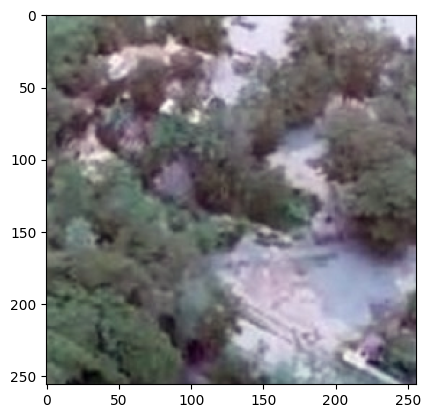

In [9]:
image_dataset = []
image_shape = []

image_type = 'Image'
image_extension = 'jpg'

for i, image_id in enumerate(image_sequence):
  if i not in [ 13,  14, 110, 128, 188, 189, 249]: # these are the files whose original image and masked image size didn't match.
    image = cv2.imread(f'{dataset_root_folder}/{dataset_name}/{image_type}/{image_id}.{image_extension}', 1)
    # plt.imshow(image)
    # image_shape.append(image.shape)
    if image is None:
      print(f"No image found for {image_type} with image ID {image_id}")
    elif image is not None:
      if image.shape[1] <= image_patch_size or image.shape[0] <= image_patch_size:
        # print(f"Small Image shape for {image_type} with image ID {image_id}")
        continue
      else:
        size_x = (image.shape[1]//image_patch_size) * image_patch_size
        size_y = (image.shape[0]//image_patch_size) * image_patch_size
        # print(image.shape)

        image = Image.fromarray(image)
        image = image.crop((0, 0, size_x, size_y))
        image = np.array(image)
        image_patches = patchify(image, (image_patch_size, image_patch_size, 3), step = image_patch_size)
        for i in range(image_patches.shape[0]):
          for j in range(image_patches.shape[1]):
            individul_patched_image = image_patches[i, j, :, :]
            # print(individul_patched_image.shape)
            individul_patched_image = minmaxscaler.fit_transform(individul_patched_image.reshape(-1, individul_patched_image.shape[-1])).reshape(individul_patched_image.shape)
            individul_patched_image = np.clip(individul_patched_image[0], 0, 1)
            plt.imshow(individul_patched_image)
            # print(individul_patched_image.shape)
            image_dataset.append(individul_patched_image)

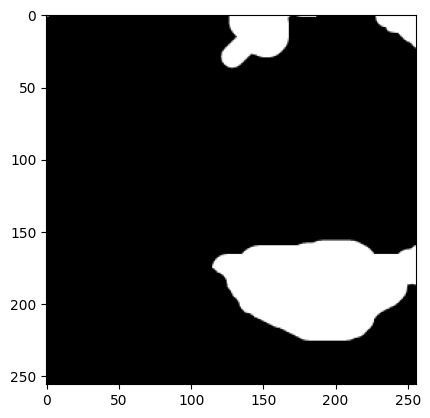

In [10]:
masked_dataset = []
masked_shape = []

image_type = 'Mask'
image_extension = 'png'


for i, image_id in enumerate(image_sequence):
  if i not in [ 13,  14, 110, 128, 188, 189, 249]:
    image = cv2.imread(f'{dataset_root_folder}/{dataset_name}/{image_type}/{image_id}.{image_extension}', 1)
    # masked_shape.append(image.shape)
    if image is None:
      print(f"No image found for {image_type} with image ID {image_id}")
    elif image is not None:
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
      if image.shape[1] <= image_patch_size or image.shape[0] <= image_patch_size:
        # print(f"Small Image shape for {image_type} with image ID {image_id}")
        pass
      else:
        size_x = (image.shape[1]//image_patch_size) * image_patch_size
        size_y = (image.shape[0]//image_patch_size) * image_patch_size
        # print(image.shape)
        image = Image.fromarray(image)
        image = image.crop((0, 0, size_x, size_y))
        image = np.array(image)
        image_patches = patchify(image, (image_patch_size, image_patch_size, 3), step = image_patch_size)
        # print(image_patches.shape)
        for i in range(image_patches.shape[0]):
          for j in range(image_patches.shape[1]):
            individul_patched_mask = image_patches[i, j, :, :]
            individul_patched_mask = individul_patched_mask[0]
            plt.imshow(individul_patched_mask)
            masked_dataset.append(individul_patched_mask)

In [11]:
print(len(image_dataset))
print(len(masked_dataset))

419
419


In [12]:
image_dataset = np.array(image_dataset)
masked_dataset = np.array(masked_dataset)

308


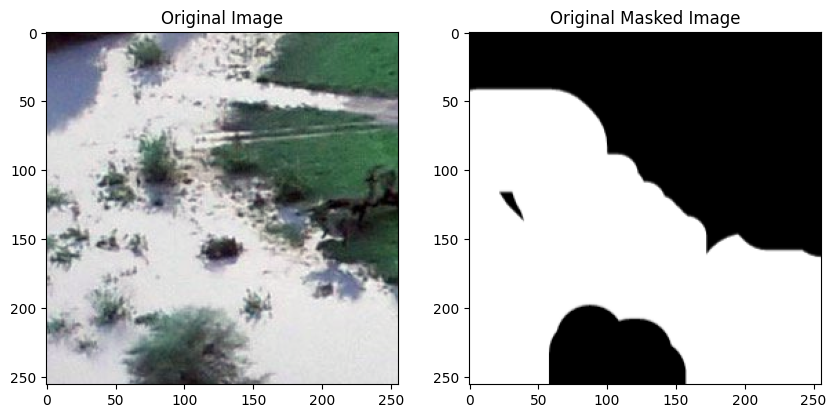

In [49]:
random_image_id = random.randint(0, len(image_dataset)-1)
print(random_image_id)

plt.figure(figsize=(10, 10))
plt.subplot(121)
plt.imshow(image_dataset[random_image_id])
plt.title("Original Image")
plt.subplot(122)
plt.imshow(masked_dataset[random_image_id])
plt.title("Original Masked Image")
plt.show()

In [14]:
class_flood = [255, 255, 255]
class_no_flood = [0, 0, 0]

In [15]:
def rgb_to_label(label):
  label_segment = np.zeros(label.shape, dtype = np.uint8)
  label_segment[np.all(label == class_no_flood, axis = -1)] = 0
  label_segment[np.all(label == class_flood, axis = -1)] = 1
  label_segment = label_segment[:, :, 0].astype(np.uint8)
  return label_segment

In [16]:
labels = []
for i in range(len(masked_dataset)):
  label = rgb_to_label(masked_dataset[i])
  labels.append(label)

In [17]:
labels = np.array(labels)

In [18]:
labels = np.expand_dims(labels, axis = 3)

In [19]:
np.unique(labels)

array([0, 1], dtype=uint8)

227


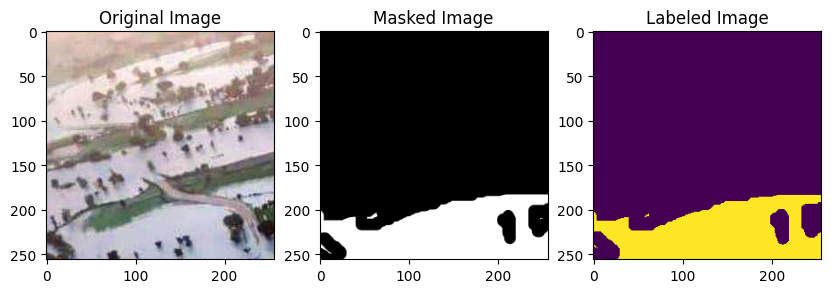

In [50]:
random_image_id = random.randint(0, len(image_dataset)-1)
print(random_image_id)

plt.figure(figsize=(10, 10))
plt.subplot(1, 3, 1)
plt.imshow(image_dataset[random_image_id])
plt.title("Original Image")
plt.subplot(1, 3, 2)
plt.imshow(masked_dataset[random_image_id])
plt.title("Masked Image")
plt.subplot(1, 3, 3)
plt.imshow(labels[random_image_id])
plt.title("Labeled Image")
plt.show()

# Training and Testing Splits

In [21]:
total_classes = len(np.unique(labels))
total_classes

2

In [22]:
from tensorflow.keras.utils import to_categorical

In [23]:
labels_categorical_dataset = to_categorical(labels, num_classes = total_classes)

In [24]:
master_training_dataset = image_dataset

In [25]:
from sklearn.model_selection import train_test_split

In [26]:
X_train, X_test, y_train, y_test = train_test_split(master_training_dataset, labels_categorical_dataset, test_size = 0.15, random_state = 42)

In [27]:
print(X_train.shape, type(X_train))
print(X_test.shape)
print(y_train.shape, type(y_train))
print(y_test.shape)

(356, 256, 256, 3) <class 'numpy.ndarray'>
(63, 256, 256, 3)
(356, 256, 256, 2) <class 'numpy.ndarray'>
(63, 256, 256, 2)


In [28]:
image_height = X_train.shape[1]
image_width = X_train.shape[2]
image_channels = X_train.shape[3]
total_classes = y_train.shape[3]

# DeepLearning U-Net Model

In [29]:
!pip install -U segmentation-models

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 4.0 MB/s eta 0:00:00


In [30]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from tensorflow.keras.layers import Conv2DTranspose, BatchNormalization, Dropout, Lambda

In [31]:
from tensorflow.keras import backend as K

In [32]:
def jaccard_coeff(y_true, y_pred):
  y_true_flatten = K.flatten(y_true)
  y_pred_flatten = K.flatten(y_pred)
  intersection = K.sum(y_true_flatten * y_pred_flatten)
  final_coef_value = (intersection + 1.0) / (K.sum(y_true_flatten)+K.sum(y_pred_flatten) - intersection + 1.0)
  return final_coef_value

## U-Net: Convolutional Neural Network Model

In [33]:
def multi_unet_model(n_classes, image_height, image_width, image_channels):
  input = Input((image_height, image_width, image_channels))

  source_input = input

  c1 = Conv2D(16, (3, 3), activation="relu", kernel_initializer="he_normal", padding = "same")(source_input)
  c1 = Dropout(0.2)(c1)
  c1 = Conv2D(16, (3, 3), activation="relu", kernel_initializer="he_normal", padding = "same")(c1)
  p1 = MaxPooling2D((2, 2))(c1)

  c2 = Conv2D(32, (3, 3), activation="relu", kernel_initializer="he_normal", padding = "same")(p1)
  c2 = Dropout(0.2)(c2)
  c2 = Conv2D(32, (3, 3), activation="relu", kernel_initializer="he_normal", padding = "same")(c2)
  p2 = MaxPooling2D((2, 2))(c2)

  c3 = Conv2D(64, (3, 3), activation="relu", kernel_initializer="he_normal", padding = "same")(p2)
  c3 = Dropout(0.2)(c3)
  c3 = Conv2D(64, (3, 3), activation="relu", kernel_initializer="he_normal", padding = "same")(c3)
  p3 = MaxPooling2D((2, 2))(c3)

  c4 = Conv2D(128, (3, 3), activation="relu", kernel_initializer="he_normal", padding = "same")(p3)
  c4 = Dropout(0.2)(c4)
  c4 = Conv2D(128, (3, 3), activation="relu", kernel_initializer="he_normal", padding = "same")(c4)
  p4 = MaxPooling2D((2, 2))(c4)

  c5 = Conv2D(256, (3, 3), activation="relu", kernel_initializer="he_normal", padding = "same")(p4)
  c5 = Dropout(0.2)(c5)
  c5 = Conv2D(256, (3, 3), activation="relu", kernel_initializer="he_normal", padding = "same")(c5)

  u6 = Conv2DTranspose(128, (2, 2), strides = (2, 2), padding = "same")(c5)
  u6 = concatenate([u6, c4])
  c6 = Conv2D(128, (3, 3), activation="relu", kernel_initializer="he_normal", padding = "same")(u6)
  c6 = Dropout(0.2)(c6)
  c6 = Conv2D(128, (3, 3), activation="relu", kernel_initializer="he_normal", padding = "same")(c6)

  u7 = Conv2DTranspose(64, (2, 2), strides = (2, 2), padding = "same")(c6)
  u7 = concatenate([u7, c3])
  c7 = Conv2D(64, (3, 3), activation="relu", kernel_initializer="he_normal", padding = "same")(u7)
  c7 = Dropout(0.2)(c7)
  c7 = Conv2D(64, (3, 3), activation="relu", kernel_initializer="he_normal", padding = "same")(c7)

  u8 = Conv2DTranspose(32, (2, 2), strides = (2, 2), padding = "same")(c7)
  u8 = concatenate([u8, c2])
  c8 = Conv2D(32, (3, 3), activation="relu", kernel_initializer="he_normal", padding = "same")(u8)
  c8 = Dropout(0.2)(c8)
  c8 = Conv2D(32, (3, 3), activation="relu", kernel_initializer="he_normal", padding = "same")(c8)

  u9 = Conv2DTranspose(16, (2, 2), strides = (2, 2), padding = "same")(c8)
  u9 = concatenate([u9, c1], axis = 3)
  c9 = Conv2D(16, (3, 3), activation="relu", kernel_initializer="he_normal", padding = "same")(u9)
  c9 = Dropout(0.2)(c9)
  c9 = Conv2D(16, (3, 3), activation="relu", kernel_initializer="he_normal", padding = "same")(c9)

  output = Conv2D(n_classes, (1, 1), activation = "softmax")(c9)

  model = Model(inputs = [input], outputs = [output])
  return model

In [34]:
metrics = ["accuracy", jaccard_coeff]

In [35]:
def get_deep_learning_model():
  return multi_unet_model(n_classes = total_classes,
                          image_height = image_height,
                          image_width = image_width,
                          image_channels = image_channels)

In [36]:
model = get_deep_learning_model()

In [37]:
# uncomment this to get model configuration
# model.get_config

## Generating Loss Function

In [38]:
weights = [0.166, 0.166]

In [39]:
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"

In [40]:
import segmentation_models as sm

Segmentation Models: using `tf.keras` framework.


In [41]:
dice_loss = sm.losses.DiceLoss(class_weights = weights)

In [42]:
focal_loss = sm.losses.CategoricalFocalLoss()

In [43]:
total_loss = dice_loss + (1 * focal_loss)

## Model Compilation

In [44]:
tf.keras.backend.clear_session()

In [45]:
model.compile(optimizer = 'adam', loss = total_loss, metrics = metrics)

In [46]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 256, 256, 16)   │            448 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 256, 256, 16)   │              0 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 256, 256, 16)   │          2,320 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 128, 128, 16)   │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 128, 128, 32)   │          4,640 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 128, 128, 32)   │              0 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 128, 128, 32)   │          9,248 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 64, 64, 32)     │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 64, 64, 64)     │         18,496 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 64, 64, 64)     │              0 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 64, 64, 64)     │         36,928 │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 32, 32, 64)     │              0 │ conv2d_5[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 32, 32, 128)    │         73,856 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 32, 32, 128)    │              0 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 32, 32, 128)    │        147,584 │ dropout_3[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 16, 16, 128)    │              0 │ conv2d_7[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)    

 Total params: 1,941,122 (7.40 MB)

 Trainable params: 1,941,122 (7.40 MB)

 Non-trainable params: 0 (0.00 B)

In [47]:
from tensorflow.keras.utils import plot_model

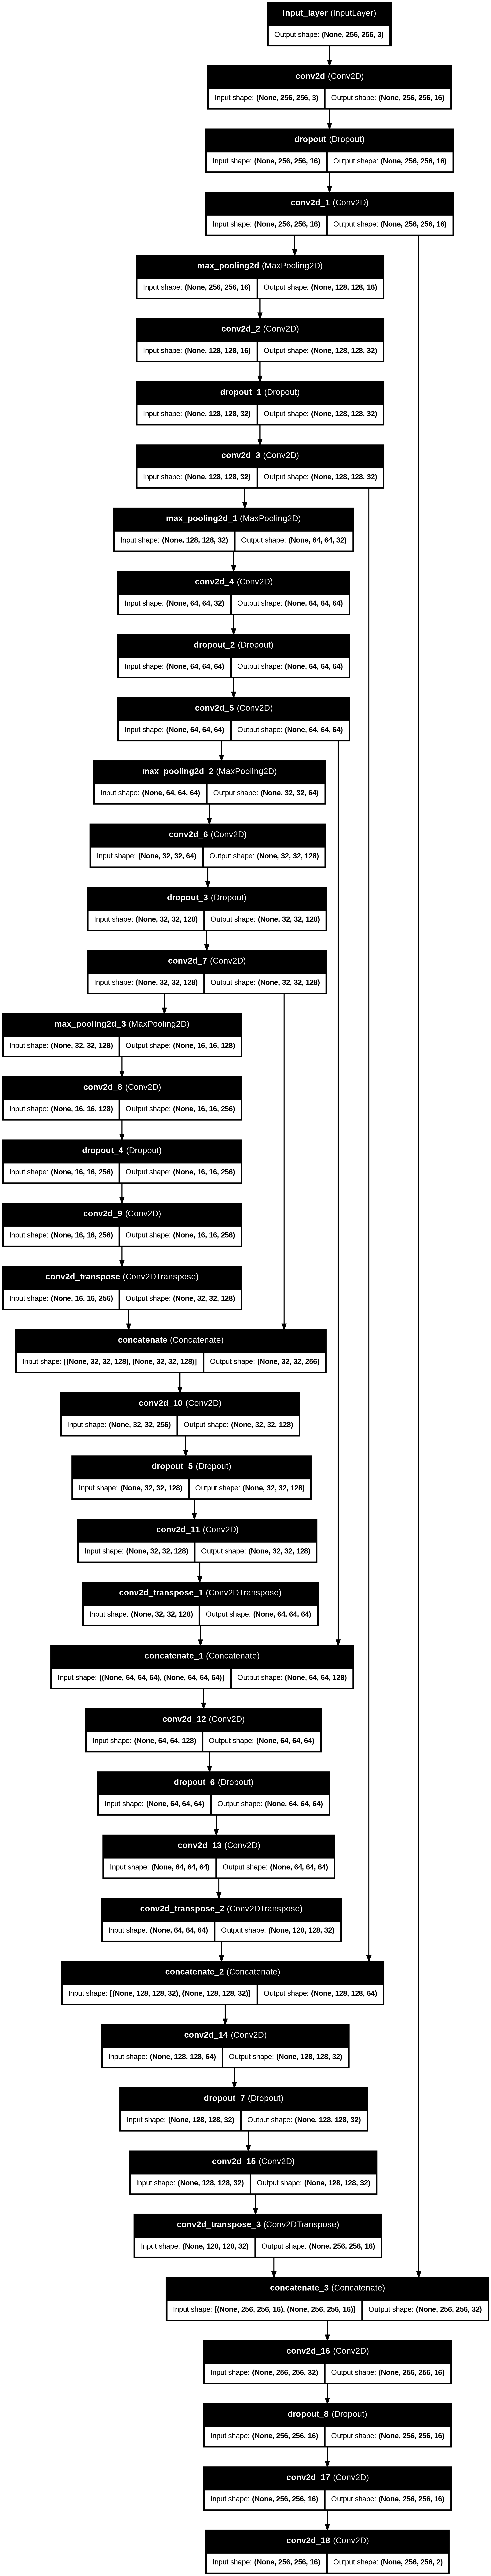

In [48]:
plot_model(model, to_file = 'flood_segmentation_detection_model_plot.png', show_shapes = True, show_layer_names = True)

## Training Part

In [51]:
model_history = model.fit(X_train, y_train, batch_size = 16,
                          verbose = 1, epochs = 10,
                          validation_data = (X_test, y_test),
                          shuffle = False)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 256, 256, 3))
  warnings.warn(msg)


23/23 ━━━━━━━━━━━━━━━━━━━━ 286s 12s/step - accuracy: 0.5784 - jaccard_coeff: 0.3610 - loss: 0.9437 - val_accuracy: 0.7302 - val_jaccard_coeff: 0.4091 - val_loss: 0.9206
Epoch 2/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 324s 12s/step - accuracy: 0.7734 - jaccard_coeff: 0.5109 - loss: 0.9108 - val_accuracy: 0.7547 - val_jaccard_coeff: 0.4617 - val_loss: 0.9111
Epoch 3/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 323s 12s/step - accuracy: 0.8026 - jaccard_coeff: 0.5429 - loss: 0.9022 - val_accuracy: 0.8404 - val_jaccard_coeff: 0.5704 - val_loss: 0.8946
Epoch 4/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 310s 12s/step - accuracy: 0.8314 - jaccard_coeff: 0.6019 - loss: 0.8951 - val_accuracy: 0.7647 - val_jaccard_coeff: 0.5427 - val_loss: 0.9103
Epoch 5/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 334s 12s/step - accuracy: 0.8357 - jaccard_coeff: 0.6079 - loss: 0.8955 - val_accuracy: 0.8224 - val_jaccard_coeff: 0.5763 - val_loss: 0.9041
Epoch 6/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 320s 12s/step - accuracy: 0.8399 - jaccard_coeff: 0.6112 - loss: 0.8964 -

In [52]:
history_a =  model_history

In [53]:
history_a.history

{'accuracy': [0.6200813055038452,
  0.7656087279319763,
  0.8063840270042419,
  0.8283405303955078,
  0.8356372714042664,
  0.8407491445541382,
  0.8488892912864685,
  0.8501866459846497,
  0.8552666306495667,
  0.8560441136360168],
 'jaccard_coeff': [0.3681941628456116,
  0.5167628526687622,
  0.5661125183105469,
  0.60039883852005,
  0.6105055809020996,
  0.611121416091919,
  0.6339012980461121,
  0.6340444087982178,
  0.644497811794281,
  0.6443220973014832],
 'loss': [0.936754047870636,
  0.9104170799255371,
  0.9011232256889343,
  0.8963046073913574,
  0.8951600193977356,
  0.8962419629096985,
  0.8912459015846252,
  0.8911702036857605,
  0.8894330263137817,
  0.8893232941627502],
 'val_accuracy': [0.7301989197731018,
  0.7547428011894226,
  0.840384840965271,
  0.76473468542099,
  0.822418212890625,
  0.8454262614250183,
  0.8242933750152588,
  0.8422563076019287,
  0.8241681456565857,
  0.8423951268196106],
 'val_jaccard_coeff': [0.4091079831123352,
  0.46172285079956055,
  0.57

## Model Performance Visualizations

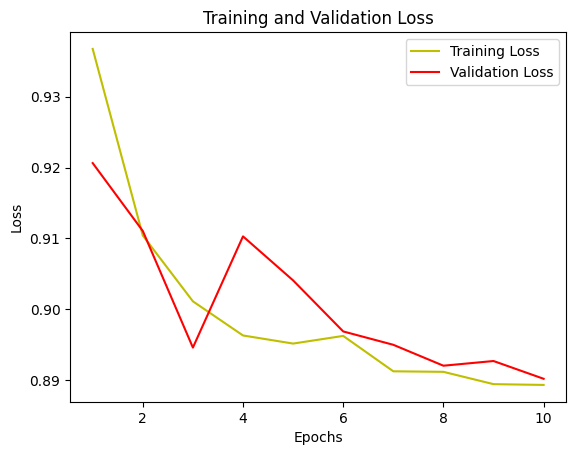

In [54]:
loss = history_a.history['loss']
val_loss = history_a.history['val_loss']

epochs = range(1, len(loss)+1)

plt.plot(epochs, loss, 'y', label = 'Training Loss')
plt.plot(epochs, val_loss, 'r', label = 'Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

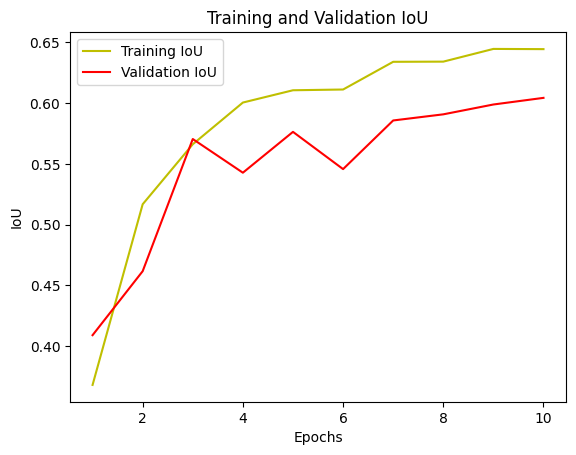

In [55]:
jaccard_coeff = history_a.history['jaccard_coeff']
val_jaccard_coeff = history_a.history['val_jaccard_coeff']

epochs = range(1, len(jaccard_coeff)+1)

plt.plot(epochs, jaccard_coeff, 'y', label = 'Training IoU')
plt.plot(epochs, val_jaccard_coeff, 'r', label = 'Validation IoU')
plt.title('Training and Validation IoU')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()
plt.show()

In [56]:
model_history.params

{'verbose': 1, 'epochs': 10, 'steps': 23}

## Predictions

In [57]:
y_pred = model.predict(X_test)

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(32, 256, 256, 3))
  warnings.warn(msg)


2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 5s/step


In [59]:
y_pred_argmax = np.argmax(y_pred, axis = 3)

In [60]:
y_test_argmax = np.argmax(y_test, axis = 3)

## Comparing Prediction results
#### using test images using masked images and predicted result images

In [61]:
test_image_number = random.randint(0, len(X_test)-1)
test_image = X_test[test_image_number]
ground_truth_image = y_test_argmax[test_image_number]

test_image_input = np.expand_dims(test_image, 0)

prediction = model.predict(test_image_input)

predicted_image = np.argmax(prediction, axis = 3)

predicted_image = predicted_image[0, :, :]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


29


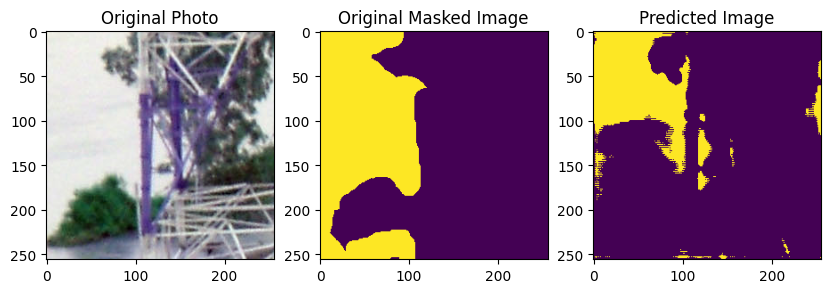

In [62]:
print(test_image_number)
# random_image_id = 50

plt.figure(figsize=(10, 10))
plt.subplot(1, 3, 1)
plt.imshow(test_image)
plt.title('Original Photo')
plt.subplot(1, 3, 2)
plt.imshow(ground_truth_image)
plt.title('Original Masked Image')
plt.subplot(1, 3, 3)
plt.imshow(predicted_image)
plt.title('Predicted Image')
plt.show()

# Saving Model to the Disk

In [63]:
model.save("flood_area_segmentation_and_prediction_model.keras")